<a href="https://colab.research.google.com/github/mratkin0/randomwalks/blob/main/BrushRW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numba
import numpy as np
import matplotlib.pyplot as plt

def random_walk_returns_histogram(k, max_steps, trials, experiment, **kwargs):
    """
    Run 'trials' random walks in k dimensions, each of length 'max_steps'.
    Return a histogram (or count) of how many times the walk is at the origin
    for each step from 0..max_steps.

    Parameters:
    -----------
    k : int
        Dimension of the lattice.
    max_steps : int
        Maximum number of steps to simulate in each random walk.
    trials : int
        Number of random-walks.

    Returns:
    --------
    returns_count : numpy array of shape (max_steps+1,)
        returns_count[s] = number of walks at the origin after step s.
        Note that returns_count[0] = trials (since all start at origin).
    """

    @numba.njit
    def finite_brush(positions, returns_count, L):
        for step in range(1, max_steps + 1):
            for w in range(trials):
                # Randomly choose a dimension for each of the 'trials' walkers to move in
                if positions[w, 0] == 0:
                    # index 0 of positions is taken as the position in a brush fibre. So if we are at the base of the fibre
                    # We are allowed to move to a neighbour on the lattice:
                    dim_to_move = np.random.randint(low=0, high=k)
                    positions[w, dim_to_move] += np.random.choice(np.array([-1, 1]))
                else:
                    # In the case when the walker is in a fibre we may only move along the fibre:
                    dim_to_move = 0
                    positions[w, 0] = abs(positions[w, 0])  # This is a hack to simplify the following code as we allow the walker on fibres to be at negative positions initially.
                    if positions[w, 0] == L:   # If we are at the end of fibre we may only move back down it
                        positions[w, dim_to_move] += -1
                    else: # If we are anywhere else on a fibre we may move in either direction
                        positions[w, dim_to_move] += np.random.choice(np.array([-1, 1]))


                # Count how many are at the origin
                returns_count[step] += np.all(positions[w] == 0)

    @numba.njit
    def Zk(positions, returns_count):
        for step in range(1, max_steps + 1):
            for w in range(trials):
                # Randomly choose a dimension for each of the 'trials' walkers to move in
                dim_to_move = np.random.randint(low=0, high=k)
                positions[w, dim_to_move] += np.random.choice(np.array([-1, 1]))

                # Count how many are at the origin
                returns_count[step] += np.all(positions[w] == 0)

    # This will track how many walks are at the origin at each step
    returns_count = np.zeros(max_steps + 1, dtype=int)

    # All walks start at origin => step 0 has 'trials' returns
    returns_count[0] = trials

    # For efficiency, keep track of positions in a single array
    # shape: (trials, k)
    if experiment == 'finite_brush':
        positions = np.zeros((trials, k+1), dtype=int)
        finite_brush(positions, returns_count, **kwargs)
    elif experiment == 'Zk':
        positions = np.zeros((trials, k), dtype=int)
        Zk(positions, returns_count)
    else:
        assert False, experiment

    return returns_count


def local_linear_regression(X, Y, x_eval, bandwidth):
    """
    Perform local (kernel) linear regression at each point in x_eval.

    Parameters
    ----------
    X : array-like of shape (N,)
        The 'x' data points (independent variable).
    Y : array-like of shape (N,)
        The 'y' data points (dependent variable).
    x_eval : array-like of shape (M,)
        The points at which we want to estimate the local slope and intercept.
    bandwidth : float
        The kernel bandwidth sigma for the Gaussian weights.

    Returns
    -------
    slopes : array-like of shape (M,)
        The local slope at each x in x_eval.
    intercepts : array-like of shape (M,)
        The local intercept at each x in x_eval.
    """
    X = np.asarray(X)
    Y = np.asarray(Y)
    x_eval = np.asarray(x_eval)

    slopes = np.zeros_like(x_eval)
    intercepts = np.zeros_like(x_eval)

    for i, x0 in enumerate(x_eval):
        # Compute Gaussian weights w_i = exp( -((X_i - x0)^2)/(2 * bandwidth^2) )
        w = np.exp(-0.5 * ((X - x0) / bandwidth)**2)

        # Build design matrix A = [ [X_i, 1], ... ] for all i
        A = np.column_stack([X, np.ones_like(X)])

        # Weighted least squares solve: (A^T W A) alpha = A^T W Y
        # We'll build the "W^(1/2)" version to do it via an unweighted lstsq:
        W_sqrt = np.sqrt(w)
        A_w = A * W_sqrt[:, None]   # shape (N, 2)
        Y_w = Y * W_sqrt           # shape (N,)

        # Solve for alpha = [slope, intercept]
        alpha, residuals, rank, s = np.linalg.lstsq(A_w, Y_w, rcond=None)
        slope, intercept = alpha

        slopes[i] = slope
        intercepts[i] = intercept

    return slopes, intercepts



def experiment(base_dimension, max_steps, trials, name, **kwargs):
    """
    base_dimension: Dimension of the underlying lattice
    max_steps: Run trials in which a walker will walk for max_steps
    trials: Number of trials to run
    name: specify the update rule which determines the structure of the lattice
    """

    # Get the histogram of how many walks return to origin at each step
    returns_count = random_walk_returns_histogram(base_dimension, max_steps, trials, experiment=name, **kwargs)
    empirical_probs = np.array(returns_count) / trials

    # Filter out steps which never arrived back at the origin
    x = np.arange(len(empirical_probs))
    ix = np.where((empirical_probs > 0) & (x > 0))

    # Return two arrays:
    # emperical_prob[ix] the proportion of trials that were at the origin at step x[ix]
    return x[ix], empirical_probs[ix]


def show_experiment_results(x, y):
  f, axs = plt.subplots(1, 2, figsize=(15,7))
  ax = axs[0]
  ax.scatter(x, y)
  ax.set_title("Probability of return to start vs walk step")
  ax.set_xlabel('Walk step')
  ax.set_ylabel('Probability at origin')
  ax.set_xscale('log')
  ax.set_yscale('log')

  bandwidth = 0.75  # you can experiment with this
  slopes, intercepts = local_linear_regression(np.log(x), np.log(y), np.log(x), bandwidth)

  ax = axs[1]
  ax.scatter(x, -2*slopes)
  ax.set_xscale('log')
  ax.set_xlabel('Planck length')
  ax.set_ylabel('Dimension')
  ax.set_title('Estimated dimension')
  plt.show()

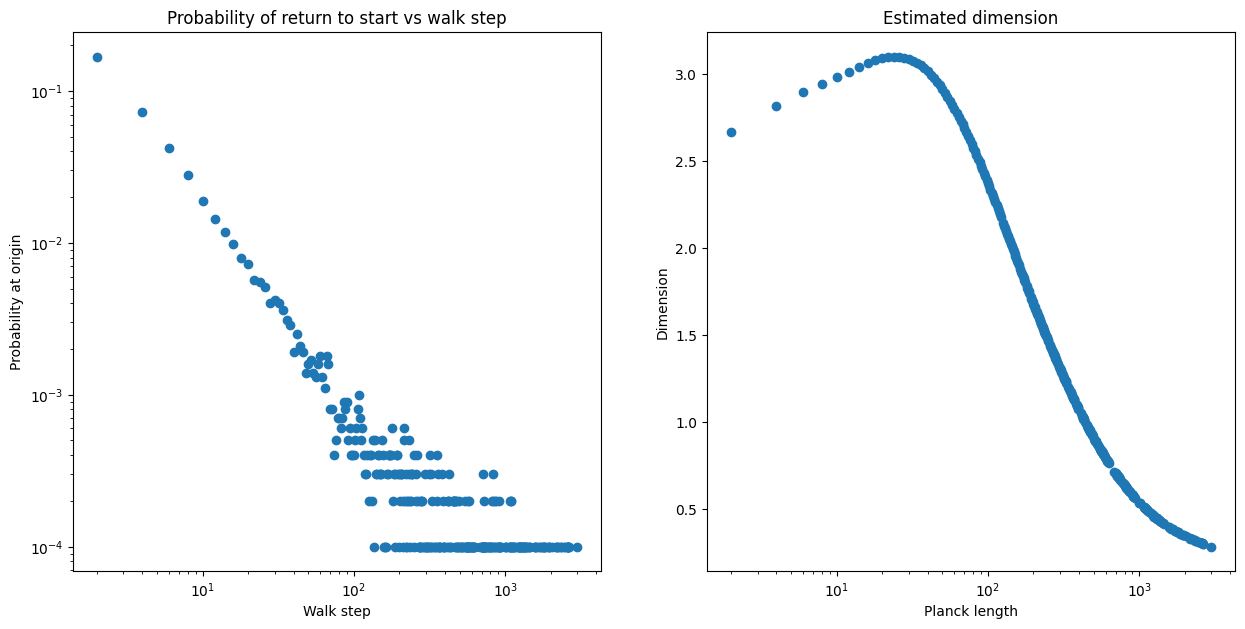

In [38]:
"""
Experiment on regular lattice of dimension k, i.e. lattice Z^k, here k=3:

In general we expect a relation like y = const * x^(-dimension/2)
So this is the same as log(y) = log(const) - dimension/2 * log(x). If we plot
log(y) vs log(x) we should get a line of gradient -dimension/2.

Below we make two plots:
1. The log(y) vs log(x) plot to see the negative slope
2. A local linear regression which computes and estimate of -2*dlog(y)/dlog(x) i.e. the
gradient in plot (1) at each x point. This gives a direct measure of the number of dimensions
at each value of x (i.e. at each step of the walk)

"""

params = dict(
    base_dimension=3,
    max_steps=3000,
    trials=10000,
    name='Zk'
)

x, y = experiment(**params)
show_experiment_results(x, y)




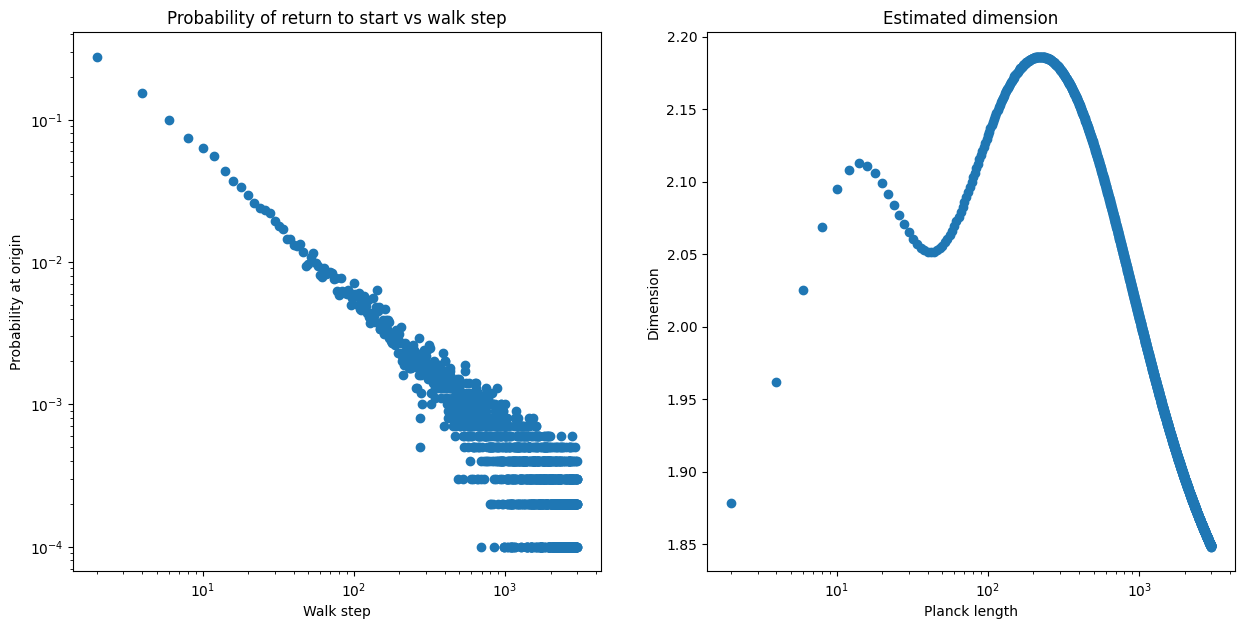

In [39]:
"""
Experiment on regular lattice of dimension k with fibres of length L=100

"""

params = dict(
    base_dimension=3,
    max_steps=3000,
    trials=10000,
    name='finite_brush',
    L=100
)

x, y = experiment(**params)
show_experiment_results(x, y)


